<a href="https://colab.research.google.com/github/ihebjer01/Human-yoga-positions-prediction/blob/main/Human_yoga_positions_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 <h1 align="center">   🧘 Lab :Yoga Class Analysis using Human pose estimation </h1>

# **Import libraries**

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')
import glob
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import glorot_uniform


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil


from IPython.display import display


%matplotlib inline

In [ ]:
train_path = "/kaggle/input/yoga-poses-dataset/DATASET/TRAIN"
test_path = "/kaggle/input/yoga-poses-dataset/DATASET/TEST"

In [ ]:
BASE_PATH = '/kaggle/input/yoga-poses-dataset/DATASET'

# 1-Data Understanding


# Objectif :
▶ The task at hand is to create a deep learning model that can automatically classify images of individuals performing various yoga poses into different categories. This problem falls under the realm of image recognition, requiring the model to analyze the images and identify their corresponding yoga poses, such as Warrior 2, Downward Facing Dog, Goddess, Plank, and Tree.


In [ ]:
import os
filenames = []
labels=[]
for dirname in os.listdir(f'/kaggle/input/yoga-poses-dataset/DATASET/TRAIN'):
    for file in os.listdir(f'/kaggle/input/yoga-poses-dataset/DATASET/TRAIN/{dirname}'):
        filenames.append(file)
        labels.append(dirname)
df_train = pd.DataFrame(data={
    'filename': filenames,
    'labels': labels
})

In [ ]:
df_train

,filename,labels
0,00000335.jpg,downdog
1,00000287.png,downdog
2,00000382.jpg,downdog
3,00000233.jpg,downdog
4,00000310.png,downdog
...,...,...
1076,00000291.jpg,goddess
1077,00000222.jpg,goddess
1078,00000205.jpg,goddess
1079,00000142.jpg,goddess


In [ ]:
import os
filenames = []
labels=[]
for dirname in os.listdir(f'/kaggle/input/yoga-poses-dataset/DATASET/TEST'):
    for file in os.listdir(f'/kaggle/input/yoga-poses-dataset/DATASET/TEST/{dirname}'):
        filenames.append(file)
        labels.append(dirname)
df_test = pd.DataFrame(data={
    'filename': filenames,
    'labels': labels
    
})

In [ ]:
df_test

,filename,labels
0,00000030.jpg,downdog
1,00000042.jpg,downdog
2,00000080.jpg,downdog
3,00000027.jpg,downdog
4,00000115.jpg,downdog
...,...,...
465,00000041.jpg,goddess
466,00000071.jpg,goddess
467,00000063.jpg,goddess
468,00000009.jpg,goddess


['downdog', 'tree', 'plank', 'warrior2', 'goddess']


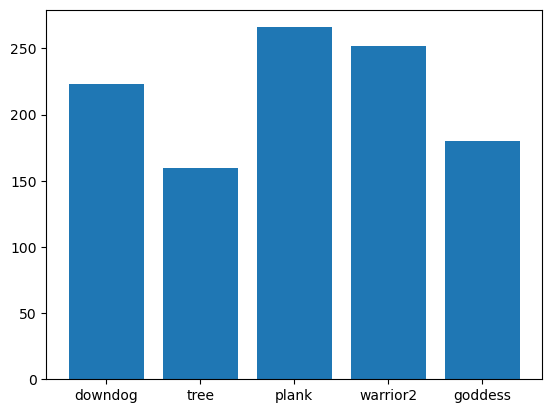

In [ ]:
num_classes = list(df_train.labels.unique())
print(num_classes)
len(num_classes)
def data_count(main_path = '/kaggle/input/yoga-poses-dataset/DATASET/TRAIN'):
    counts = {}
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in num_classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts
counts = data_count()
plt.bar(list(counts.keys()),list(counts.values()))
plt.show()

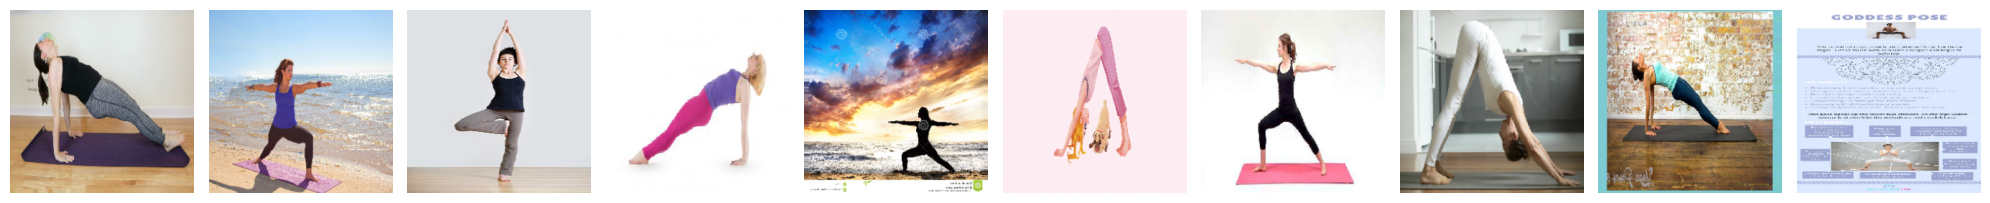

In [ ]:
imgs, labels = next(train_generator)
def plotImages(images_arr):
 
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    image = np.clip(img, 0, 1)
    ax.imshow(image)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
plotImages(imgs)

In [ ]:
# Counting the training samples
Total_sample=0
for i in os.listdir(train_path):
    print(f'Length of :{i}= {len(os.listdir(os.path.join(train_path,i)))}')
    Total_sample+=len(os.listdir(os.path.join(train_path,i)))
print(f'Total Samples: { Total_sample}')

Length of :downdog= 223
Length of :tree= 160
Length of :plank= 266
Length of :warrior2= 252
Length of :goddess= 180
Total Samples: 1081


In [ ]:
# Counting the testing samples
Total_sample=0
for i in os.listdir(test_path):
    print(f'Length of :{i}= {len(os.listdir(os.path.join(test_path,i)))}')
    Total_sample+=len(os.listdir(os.path.join(test_path,i)))
print(f'Total Samples:{Total_sample}')

Length of :downdog= 97
Length of :tree= 69
Length of :plank= 115
Length of :warrior2= 109
Length of :goddess= 80
Total Samples:470


### Consisting of 1,547 images split into 5 classes, or poses, this dataset is smaller and contains less poses than will be necessary for later phases of the project. However, for this initial phase, it contains enough images to investigate how different models will perform.

### we started by creating Directories for Training and validation ,Then splits the dataset  into train, validation sets. then copy images from their origine the appropriate directories

In [ ]:
os.makedirs('/kaggle/working/Train')
os.makedirs('/kaggle/working/Validation')


In [ ]:


# Move images to train, validation, or test directories based on random split
for folder in os.listdir('/kaggle/input/yoga-poses-dataset/DATASET/TRAIN'):
    images = os.listdir(os.path.join('/kaggle/input/yoga-poses-dataset/DATASET/TRAIN', folder))
    train_images, test_images = train_test_split(images, test_size=0.1)
    train_images, val_images = train_test_split(train_images, test_size=0.1)
    for image in train_images:
        src = os.path.join('//kaggle/input/yoga-poses-dataset/DATASET/TRAIN', folder, image)
        dst = os.path.join('/kaggle/working/Train', folder, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)
    for image in val_images:
        src = os.path.join('/kaggle/input/yoga-poses-dataset/DATASET/TRAIN', folder, image)
        dst = os.path.join('/kaggle/working/Validation', folder, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

In [ ]:
train_dir = '/kaggle/working/Train'
val_dir = '/kaggle/working/Validation'
test_dirr='/kaggle/input/yoga-poses-dataset/DATASET/TEST'

In [ ]:
VAL_SPLIT = 0.15
IMAGE_SIZE = 256
IMAGE_CHAN = 3
BATCH_SIZE = 64
CLASSES = os.listdir(train_dir)
NUM_CLASSES = len(CLASSES)
EPOCHS = 30

In [ ]:
train_gen = ImageDataGenerator(
                                rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.1,
                                fill_mode='nearest',
                                horizontal_flip=True,
                                validation_split=VAL_SPLIT
                                )

# Create Data Loaders for training and validation sets
train_generator = train_gen.flow_from_directory(
                                train_dir,
                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='categorical',
                                subset='training')

val_generator = train_gen.flow_from_directory(
                                val_dir,
                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='categorical',
                                subset='validation')

# Create Image Data Generator and Data Loader for test set

test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_directory(
                                test_dirr,
                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='categorical')

Found 882 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


# **3- Data Modeling & Model Evaluation**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHAN)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [ ]:
class earlyStopAcc(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.99:
            self.model.stop_training = True
            print('Reached 99% accuracy, stopping training.')

callbacks = earlyStopAcc()

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[callbacks])


Epoch 1/30
14/14 [==============================] - 31s 2s/step - loss: 1.6043 - accuracy: 0.2619 - val_loss: 1.5912 - val_accuracy: 0.2400
Epoch 2/30
14/14 [==============================] - 26s 2s/step - loss: 1.5949 - accuracy: 0.2483 - val_loss: 1.5561 - val_accuracy: 0.2400
Epoch 3/30
14/14 [==============================] - 25s 2s/step - loss: 1.5017 - accuracy: 0.3469 - val_loss: 1.0434 - val_accuracy: 0.6000
Epoch 4/30
14/14 [==============================] - 25s 2s/step - loss: 1.3482 - accuracy: 0.4444 - val_loss: 0.9899 - val_accuracy: 0.5600
Epoch 5/30
14/14 [==============================] - 26s 2s/step - loss: 1.1568 - accuracy: 0.5556 - val_loss: 0.7801 - val_accuracy: 0.7600
Epoch 6/30
14/14 [==============================] - 26s 2s/step - loss: 1.0445 - accuracy: 0.5907 - val_loss: 0.5066 - val_accuracy: 0.8400
Epoch 7/30
14/14 [==============================] - 26s 2s/step - loss: 0.9500 - accuracy: 0.6190 - val_loss: 0.5279 - val_accuracy: 0.8000
Epoch 8/30
14/14 [==

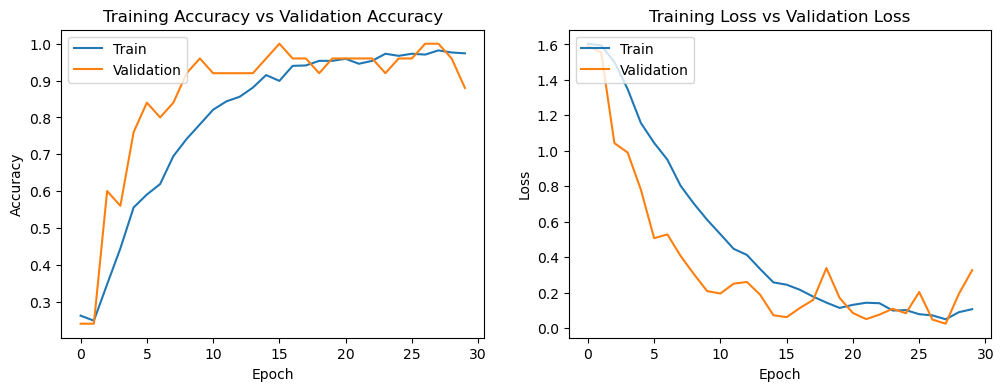

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
test_predict = model.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 [==============================] - 13s 2s/step - loss: 0.5757 - accuracy: 0.8511


In [ ]:
CLASSES = os.listdir(train_dir)


In [ ]:
Y_test = []
for i in range(len(test_generator)):
    for j in test_generator[i][1]:
        Y_test.append(np.argmax(j))
y_pred = np.argmax(model.predict(test_generator), axis=1)
print(classification_report(Y_test, y_pred, target_names=CLASSES))

8/8 [==============================] - 13s 2s/step
              precision    recall  f1-score   support

    warrior2       0.81      0.98      0.88        97
     goddess       0.79      0.72      0.76        80
     downdog       0.90      0.80      0.85       115
        tree       0.95      0.90      0.93        69
       plank       0.83      0.85      0.84       109

    accuracy                           0.85       470
   macro avg       0.86      0.85      0.85       470
weighted avg       0.85      0.85      0.85       470



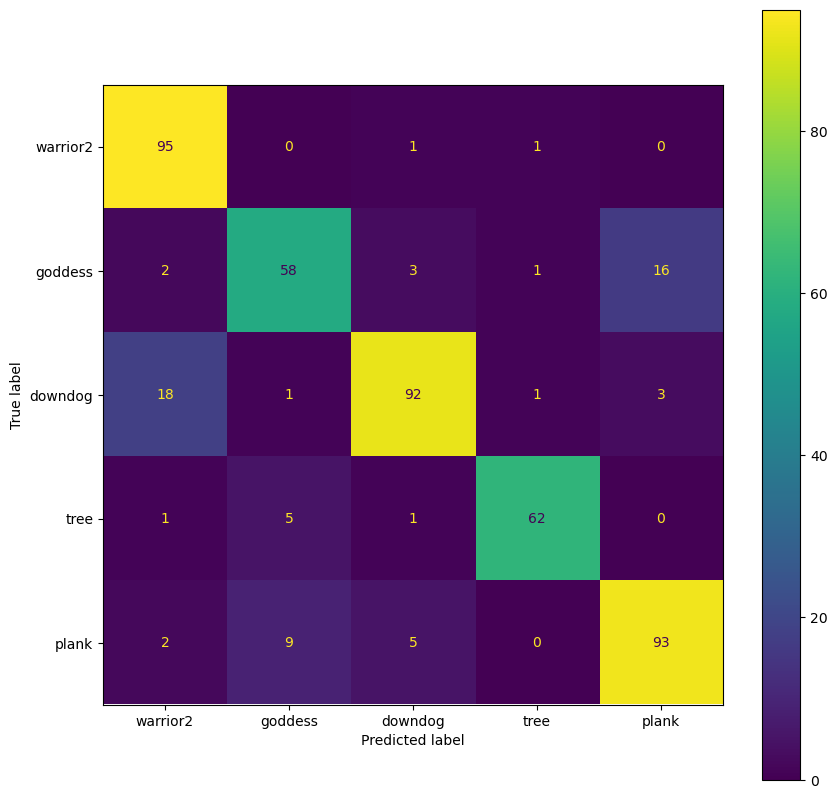

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_pred)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [ ]:
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy:', accuracy)

Accuracy: 0.851063829787234


1/1 [==============================] - 0s 126ms/step
[[0. 1. 0. 0. 0.]]


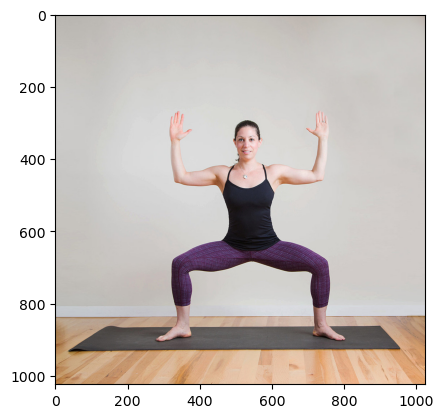

In [ ]:
import matplotlib.pyplot as plot
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
img = load_img('/kaggle/input/yoga-poses-dataset/DATASET/TEST/goddess/00000000.jpg', target_size=(IMAGE_SIZE, IMAGE_SIZE))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
print(classes)
img = Image.open('/kaggle/input/yoga-poses-dataset/DATASET/TEST/goddess/00000000.jpg')
img_array = np.array(img)

plt.imshow(img_array)
plt.show()

### Model 2:

#### Transfer Learning
#### This next section will import an Inception model pre-trained on the famous ImageNet dataset. Taking advantage of all the features learned in that pre-training might produce a better classifier for this new task


In [ ]:
inception_model = InceptionV3(
                        input_shape =(IMAGE_SIZE, IMAGE_SIZE ,IMAGE_CHAN),
                        include_top = False,
                        weights='imagenet'
                        )

for layer in inception_model.layers:
    layer.trainable = False

last_layer = inception_model.get_layer('mixed7')
last_output = last_layer.output

In [ ]:
# Add new layers to perform classification on the new dataset with number of classes as the last layers outputs
model3 = tf.keras.layers.Flatten()(last_output)
model3 = tf.keras.layers.Dense(1024, activation='relu')(model3)
model3 = tf.keras.layers.Dropout(0.2)(model3)                  
model3 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(model3)           

pretrained_model = tf.keras.Model(inception_model.input, model3) 

pretrained_model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
pretrained_hist = pretrained_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[callbacks])


Epoch 1/30
14/14 [==============================] - 32s 2s/step - loss: 12.1964 - accuracy: 0.4864 - val_loss: 0.7541 - val_accuracy: 0.8400
Epoch 2/30
14/14 [==============================] - 26s 2s/step - loss: 1.1542 - accuracy: 0.8639 - val_loss: 0.5035 - val_accuracy: 0.9200
Epoch 3/30
14/14 [==============================] - 26s 2s/step - loss: 0.3295 - accuracy: 0.9422 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 4/30
14/14 [==============================] - 26s 2s/step - loss: 0.1718 - accuracy: 0.9592 - val_loss: 0.1091 - val_accuracy: 0.9600
Epoch 5/30
14/14 [==============================] - 25s 2s/step - loss: 0.1278 - accuracy: 0.9626 - val_loss: 0.0737 - val_accuracy: 0.9600
Epoch 6/30
14/14 [==============================] - 26s 2s/step - loss: 0.0785 - accuracy: 0.9751 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 7/30
14/14 [==============================] - 26s 2s/step - loss: 0.0516 - accuracy: 0.9875 - val_loss: 0.0903 - val_accuracy: 0.9600
Epoch 8/30
14/14 [=

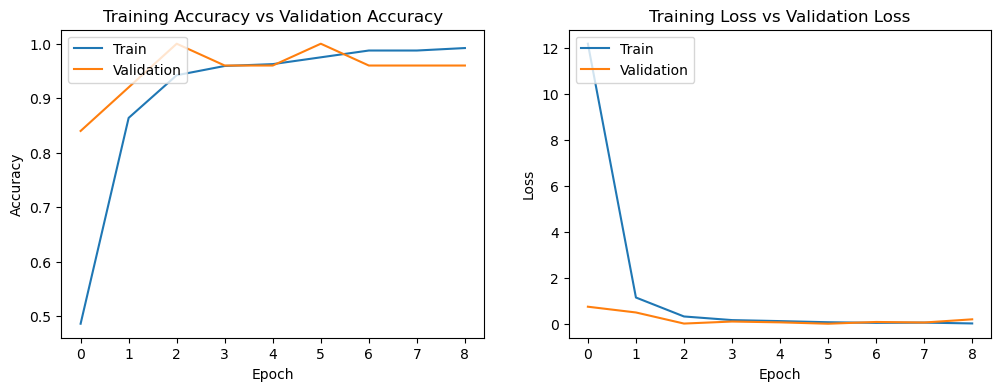

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = pretrained_hist.history['accuracy']
train_loss = pretrained_hist.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(pretrained_hist.history['accuracy'])
ax[0].plot(pretrained_hist.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(pretrained_hist.history['loss'])
ax[1].plot(pretrained_hist.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
test_predict2 = pretrained_model.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 [==============================] - 13s 2s/step - loss: 0.2169 - accuracy: 0.9553


In [ ]:
Y_test = []
for i in range(len(test_generator)):
    for j in test_generator[i][1]:
        Y_test.append(np.argmax(j))
y_pred2 = np.argmax(pretrained_model.predict(test_generator), axis=1)
print(classification_report(Y_test, y_pred2, target_names=CLASSES))

8/8 [==============================] - 14s 2s/step
              precision    recall  f1-score   support

    warrior2       0.98      0.98      0.98        97
     goddess       0.90      0.90      0.90        80
     downdog       0.95      0.98      0.97       115
        tree       0.99      0.97      0.98        69
       plank       0.96      0.94      0.95       109

    accuracy                           0.96       470
   macro avg       0.96      0.95      0.95       470
weighted avg       0.96      0.96      0.96       470



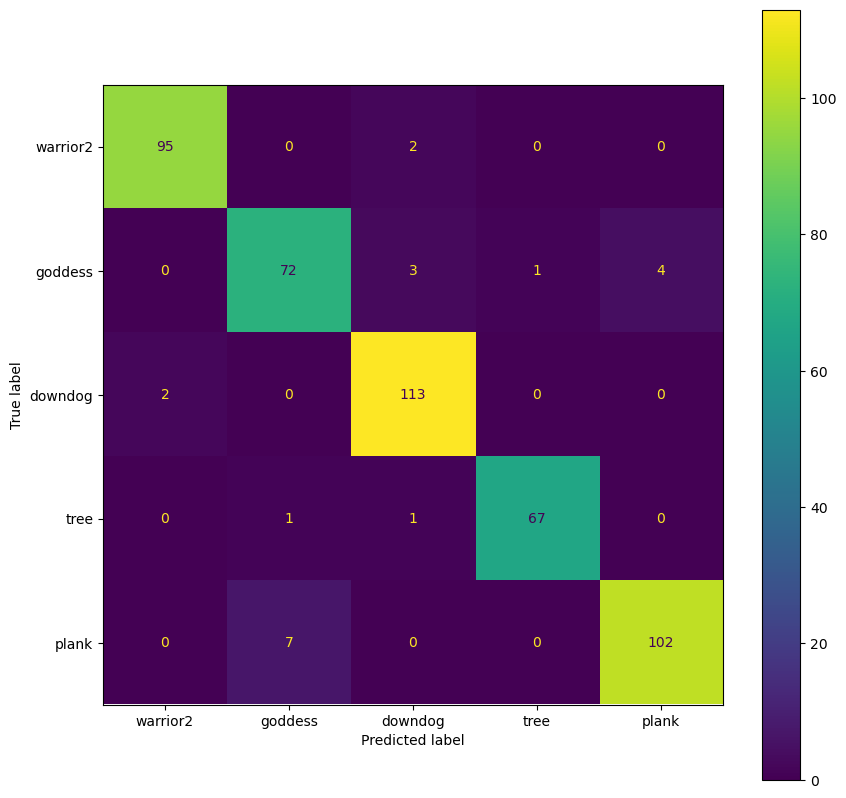

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_pred2)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

#### Apply a model to an image of the test set 

1/1 [==============================] - 0s 28ms/step
[[1.0353713e-14 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]]


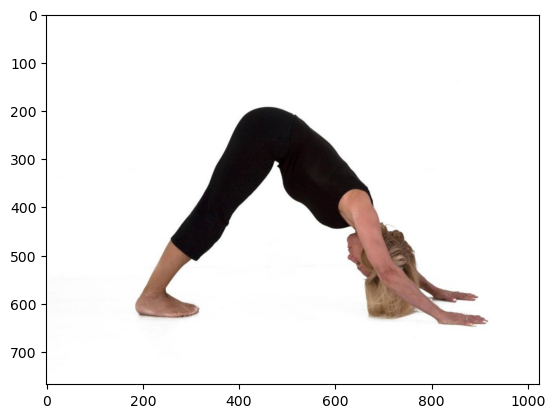

In [ ]:
import matplotlib.pyplot as plot
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
img = load_img('/kaggle/input/yoga-poses-dataset/DATASET/TEST/downdog/00000026.jpg', target_size=(IMAGE_SIZE, IMAGE_SIZE))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = pretrained_model.predict(img_data)
print(classes)
img = Image.open('/kaggle/input/yoga-poses-dataset/DATASET/TEST/downdog/00000026.jpg')
img_array = np.array(img)

plt.imshow(img_array)
plt.show()